In [1]:
import sys
sys.path.append('../Codes/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math
import json

Text_files_path = '../../../../Dropbox/Research/Evolution_Immune_System/Text_files/'

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


In [2]:
%%time
n_seq = 800000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( Text_files_path + "Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )
print('Master Seq:', Sequences[0].sequence, 'Antigen Seq:', Sequences[0].complementary_sequence)

Master Seq: cccccgdcc Antigen Seq: hefqnrihq
CPU times: user 6.95 s, sys: 515 ms, total: 7.46 s
Wall time: 8.14 s


In [4]:
M2 = np.loadtxt('../../../../Dropbox/Research/Evolution_Immune_System/Text_files/MJ2.txt', skiprows= 1, usecols=range(1,21)).tolist()

In [90]:
antigen_seq = 'hefqnrihq'
master_sequence_energy = Sequences[0].energy
master_seq = Sequences[0].sequence

antigen_seq_2 = find_complementary_seq(sequence = master_seq , Energy_Matrix =  M2)
Antigen_seq = Sequence(seq_id = 0, parent = antigen_seq, energy_parent = master_sequence_energy, Master_Seq=True, master_sequence = antigen_seq, complementary_sequence = master_seq, Energy_Matrix = M2)


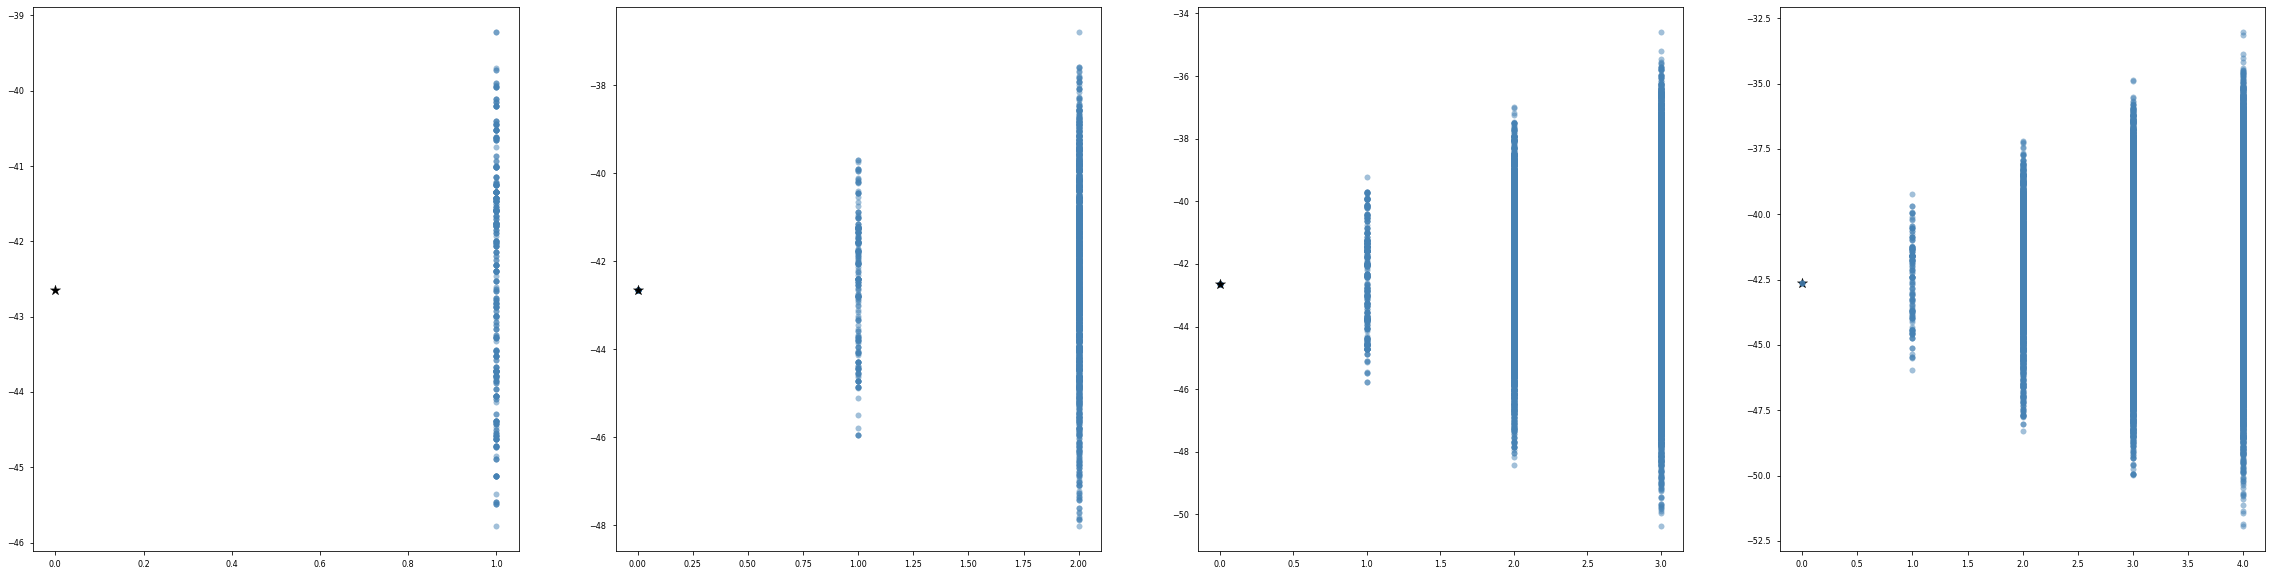

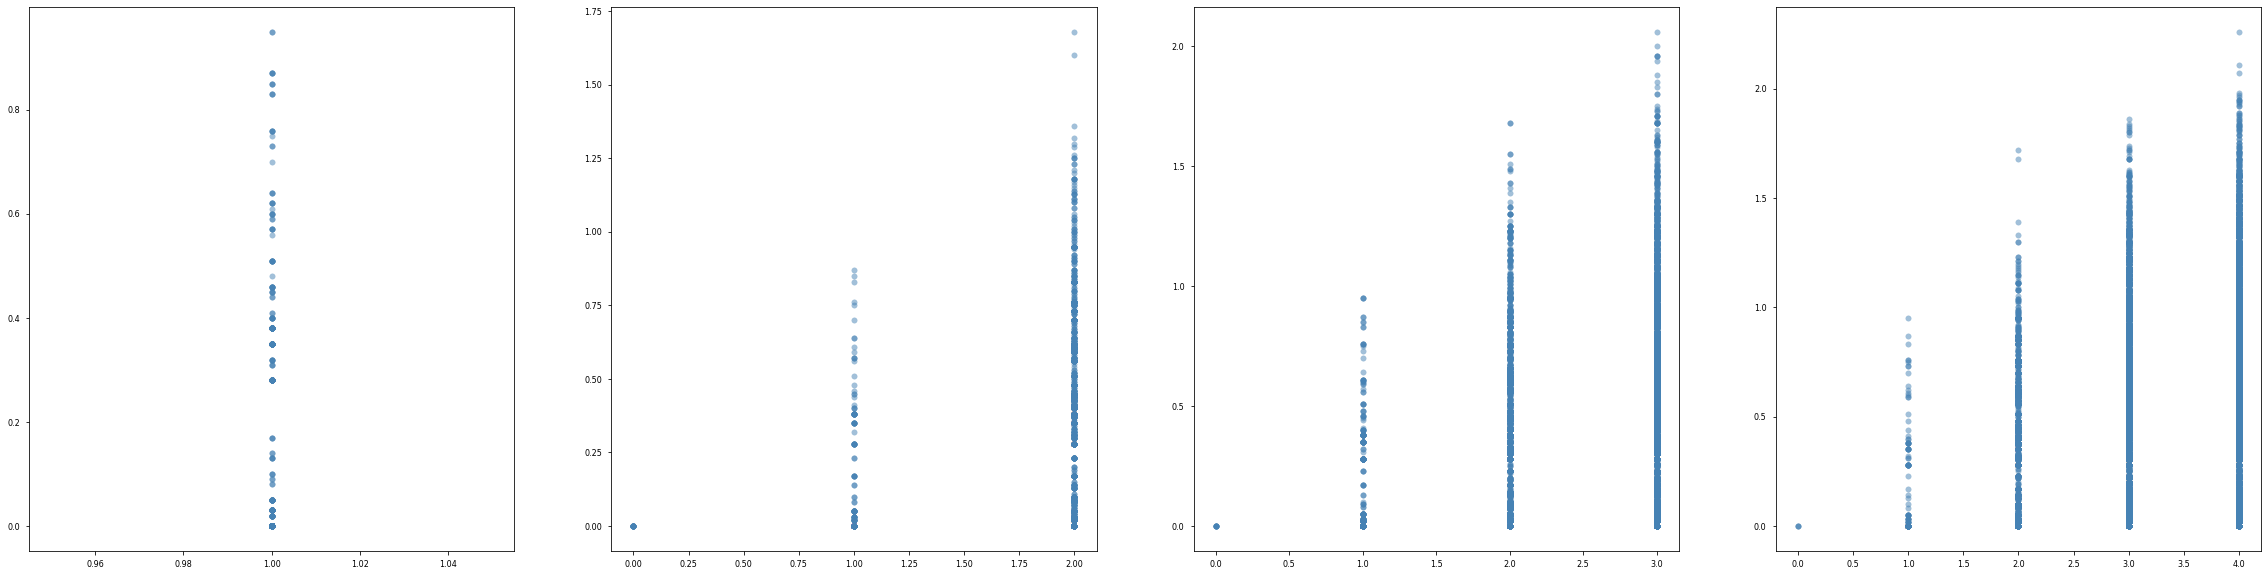

In [110]:
fig, ax = plt.subplots(1, 4, figsize = (40, 10))
fig2, ax2 = plt.subplots(1, 4, figsize = (40, 10))

Ts = [400, 4000, 40000, 80000]
for d in range(1,5):
    Antigen_seq = Sequence(seq_id = 0, parent = antigen_seq, energy_parent = master_sequence_energy, Master_Seq=True, master_sequence = antigen_seq, complementary_sequence = master_seq, Energy_Matrix = M2)
    ax[d-2].scatter(0, Antigen_seq.energy, marker = '*', s = 120, color = 'black')
    trajectory_e = np.array([])
    trajectory_d = np.array([])
    
    delta_e_peak_ms = np.array([])

    T = Ts[d-1]
    counter = 0
    for t in range(T):
        Antigen_seq.mutate_sequence(Energy_Matrix = M2)
        Antigen_seq.energy_parent = Antigen_seq.energy
        counter += 1
        if(counter == d):
            trajectory_e = np.append(trajectory_e, Antigen_seq.energy)
            trajectory_d = np.append(trajectory_d, Antigen_seq.hamming_distance)
            new_master_seq = find_complementary_seq(Antigen_seq.sequence, M2)
            new_master_seq_energy = calculate_energy(M2, new_master_seq, Antigen_seq.sequence)
            delta_e_peak_ms = np.append(delta_e_peak_ms, Antigen_seq.energy - new_master_seq_energy)
            Antigen_seq = Sequence(seq_id = 0, parent = antigen_seq, energy_parent = master_sequence_energy, Master_Seq=True, master_sequence = antigen_seq, complementary_sequence = master_seq, Energy_Matrix = M2)
            counter = 0

    ax[d-1].scatter(trajectory_d, trajectory_e, color =  'steelblue', alpha = 0.5)
    ax2[d-1].scatter(trajectory_d, delta_e_peak_ms, color =  'steelblue', alpha = 0.5)
    


array([-47.66, -47.65, -47.94, -47.59])

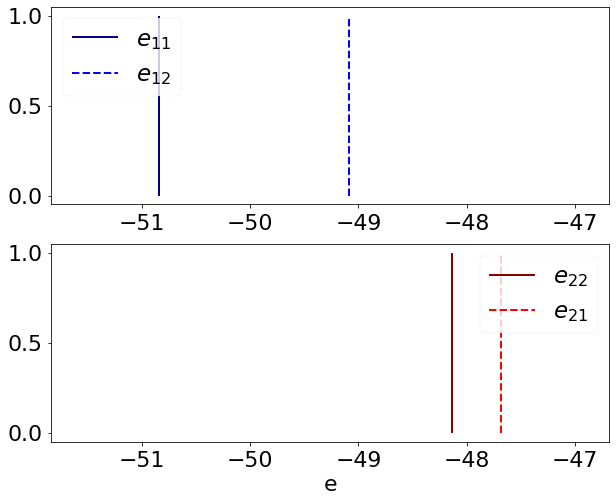

In [19]:
data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_4_.txt")
data = data[100,:]
fig, ax = plt.subplots(2,1,figsize=(10,8))

ax[0].vlines(data[0], 0, 1, color = 'darkblue', linestyle = '-', label = r'$e_{11}$', linewidth = 2)
ax[0].vlines(data[1], 0, 1, color = 'blue', linestyle = '--', label = r'$e_{12}$', linewidth = 2)
ax[1].vlines(data[2], 0, 1, color = 'darkred', linestyle = '-', label = r'$e_{22}$', linewidth = 2)
ax[1].vlines(data[3], 0, 1, color = 'red', linestyle = '--', label = r'$e_{21}$', linewidth = 2)

ax[0].set_xlim(np.min(data)-1, np.max(data)+1)
ax[1].set_xlim(np.min(data)-1, np.max(data)+1)

ax[0].legend(fontsize = 23, loc = 2)
ax[1].legend(fontsize = 23, loc = 1)

ax[0].tick_params(labelsize = 22)
ax[1].tick_params(labelsize = 22)

ax[1].set_xlabel(r'e', fontsize = 22)

fig.savefig("../Figures/2_Wandering_in_Antigen_space/example41.png")

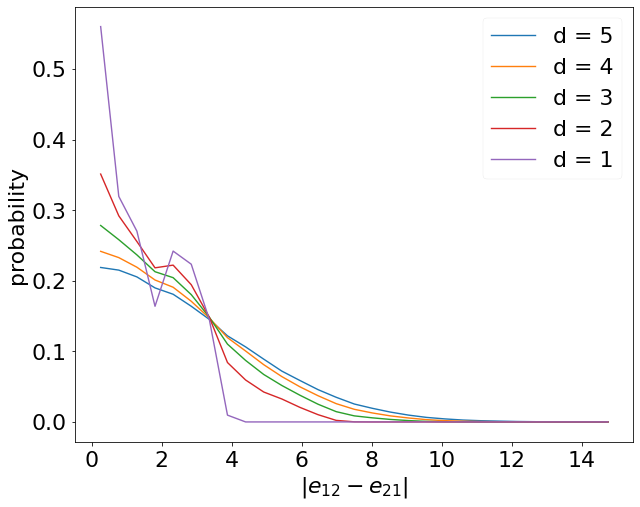

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(abs(data[:,1]-data[:,3]), bins = np.linspace(0,15,30), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$|e_{12}-e_{21}|$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_abs.png')


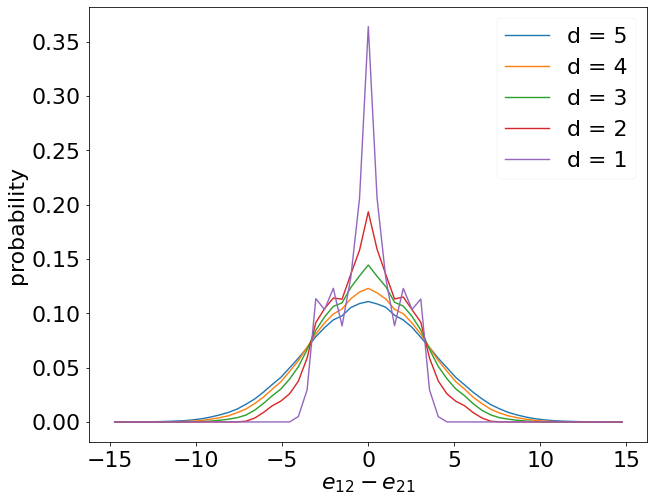

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(data[:,1]-data[:,3], bins = np.linspace(-15,15,60), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$e_{12}-e_{21}$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies.png')


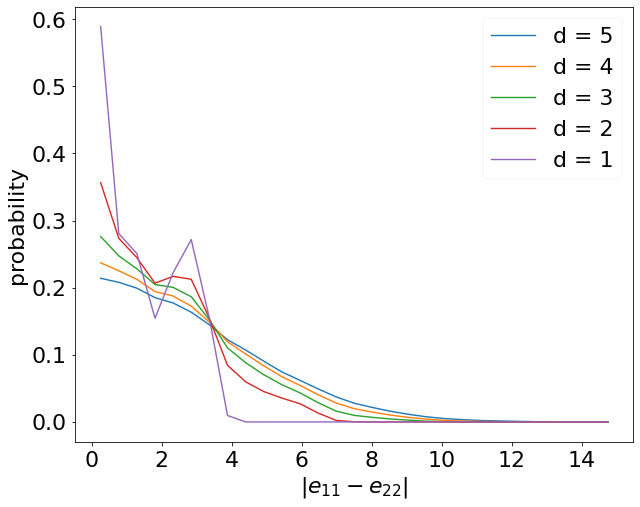

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(abs(data[:,0]-data[:,2]), bins = np.linspace(0,15,30), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$|e_{11}-e_{22}|$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_MS_abs.png')



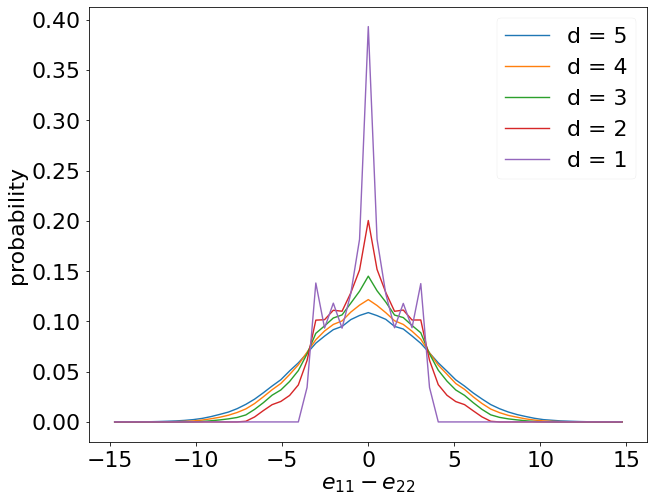

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(data[:,0]-data[:,2], bins = np.linspace(-15,15,60), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$e_{11}-e_{22}$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_MS.png')


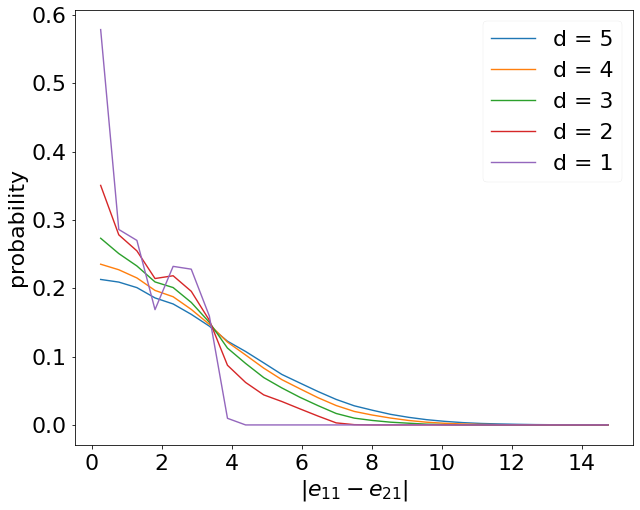

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(abs(data[:,0]-data[:,3]), bins = np.linspace(0,15,30), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$|e_{11}-e_{21}|$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_1_abs.png')


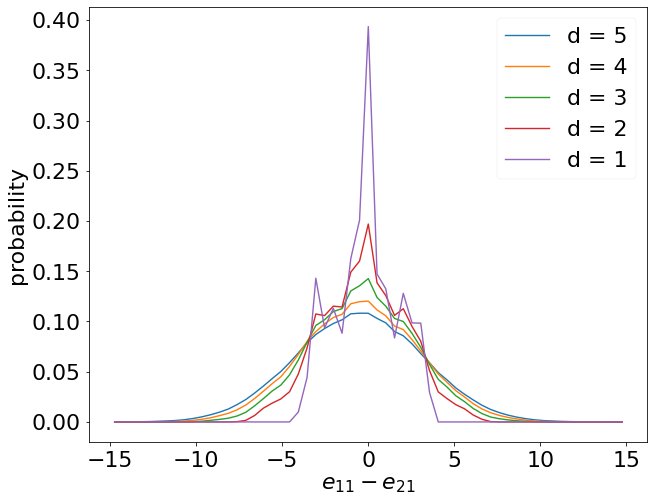

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(data[:,0]-data[:,3], bins = np.linspace(-15,15,60), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$e_{11}-e_{21}$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_1.png')



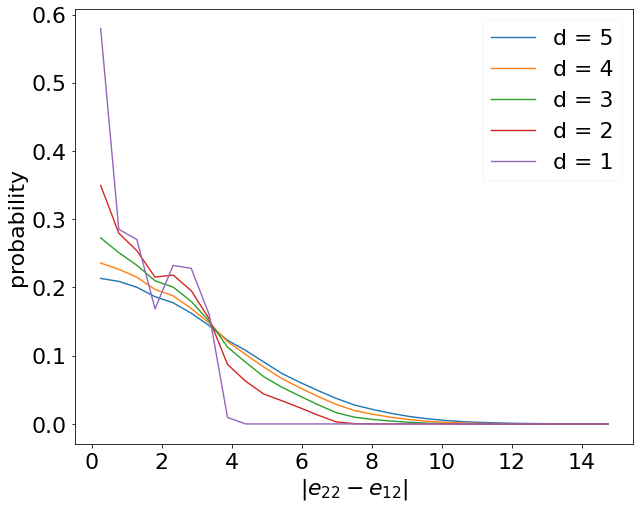

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(abs(data[:,2]-data[:,1]), bins = np.linspace(0,15,30), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$|e_{22}-e_{12}|$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_2_abs.png')



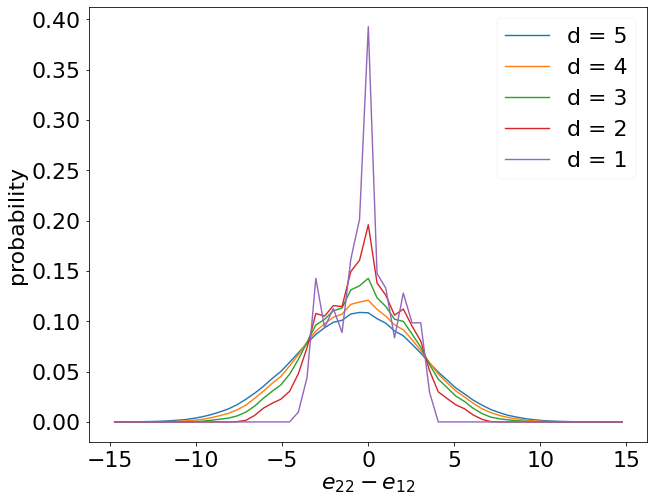

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    data_d = np.histogram(data[:,2]-data[:,1], bins = np.linspace(-15,15,60), density = True)
    ax.plot((data_d[1][:-1] + data_d[1][1:])/2, data_d[0], label = "d = %d"%(M))

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22)
ax.set_xlabel(r'$e_{22}-e_{12}$', fontsize = 22)
ax.set_ylabel('probability', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/diff_energies_2.png')


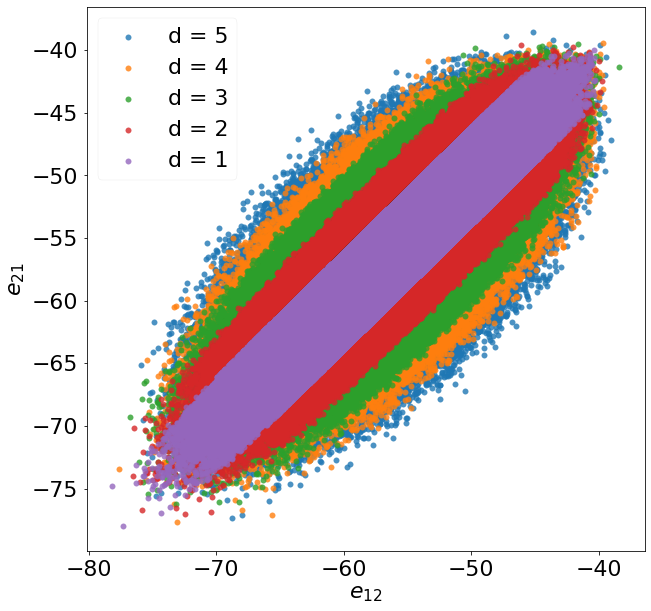

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    ax.scatter(data[:,1], data[:,3] , label = "d = %d"%(M), alpha = 0.8)

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22, loc = 2)
ax.set_xlabel(r'$e_{12}$', fontsize = 22)
ax.set_ylabel(r'$e_{21}$', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/scatter_energies.png')



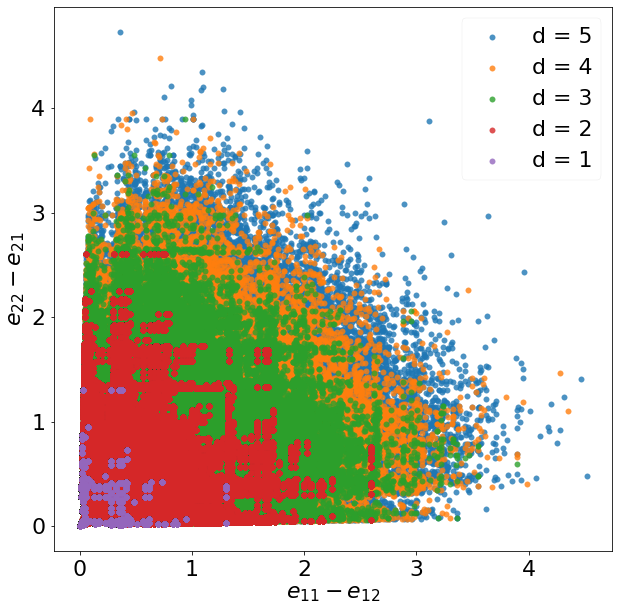

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
for M in np.flip(range(1,6)):
    data = np.loadtxt(Text_files_path + "Antigenic/energies_hamming_distance_%d_.txt"%(M))
    ax.scatter(data[:,1]-data[:,0], data[:,3]-data[:,2] , label = "d = %d"%(M), alpha = 0.8)

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22, loc = 1)
ax.set_xlabel(r'$e_{11}-e_{12}$', fontsize = 22)
ax.set_ylabel(r'$e_{22}-e_{21}$', fontsize = 22)
fig.savefig('../Figures/2_Wandering_in_Antigen_space/scatter_diff_energies.png')

